In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.integrate import odeint
import scipy.fftpack as fft
from scipy import interpolate

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

## For reference
\begin{align}
\hat{V}(k) &= \int_{0}^{1} V(x)e^{-2\pi\;i\;k\;x}dx \\ \\
V(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{V}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{V}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{V}(k)
\end{align}

In [3]:
# FFT solver :
def fft_poisson(rho,dx):
    # finding the frequency space for rho
    kspace = fft.fftfreq(len(rho), d = dx)
    rho_kspace = fft.fft(rho)

    V_kspace = np.zeros(len(rho))
    
    # V(k) = (1/(4(pi k)^{2})) rho(k)
    
    V_kspace[1:] =  (1/(4 * np.pi**2 * kspace[1:]**2)) * rho_kspace[1:]
    V_kspace[0]  =  (1/(4 * np.pi**2)) * np.sum(rho)/(len(rho))

    E_kspace =  -1j * 2 * np. pi * kspace * V_kspace

    # taking inverse fourier transform for the potential
    
    V = fft.ifft(V_kspace)

    V = (V.real).astype(np.double)

    # Taking inverse fourier transform for the electric field
    
    E = fft.ifft(E_kspace)

    E = (E.real).astype(np.double)

    return V, E

In [4]:
# b1 charge depositor
def cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx):
    
    # Assigning particle charge to left grid point
    left_corner_charge  = (1 - frac_x) * charge / (dx)
    # Assigning particle charge to right grid point
    right_corner_charge = (frac_x) * charge / (dx)

    
    # Storing the respective indices of left and right grid points
    left_corners  = zone_x.copy()
    right_corners = left_corners + 1

    
    # Joining the indices and charges into one vector each
    corners = np.concatenate([left_corners, right_corners], axis=0)
    charges = np.concatenate([left_corner_charge, right_corner_charge], axis=0)

    # Charge deposition using numpy histogram in a vectorized manner
    
    rho, temp = np.histogram(corners, bins=len(x_grid), range=(0, len(x_grid)), weights=charges)
    
    # Applying periodic BC's for charge depostions from last and first zone since 
    # first and the last x_grid point are the same point according to periodic BC's
    # Since first and last point are the same, charge being deposited on the last grid point
    # must also be deposited on the first grid point
    
    rho[0]  = rho[0] + rho [-1]
    rho[-1] = rho[0].copy()
    
    return rho

In [5]:
# Particle parameters
k_boltzmann     = 1
mass_electron   = 1
tempertature    = 1
charge_electron = -1
charge_ion      = +1

In [6]:
# Setting the length of the domain
length_domain_x = 1

In [7]:
# Setting number of particle in the domain
number_of_electrons = 1000000

In [8]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)

# setting the mean and standard deviation of the maxwell distribution

mu, sigma = 0, (k_boltzmann * tempertature / mass_electron)

# Initializing the velocitites according to the maxwell distribution

velocity_x = np.random.normal(mu, sigma, number_of_electrons)

In [9]:
# Divisions in x grid
divisions_domain_x = 100

x_grid = np.linspace(0, length_domain_x, divisions_domain_x + 1, endpoint=True)

dx = x_grid[1] - x_grid[0]

In [10]:
def set_up_perturbation(positions_x, number_particles, divisions_perturbed, amplitude , k, length_domain_x):

    length_domain_x * np.random.rand(number_of_electrons)

    particles_uptill_current_x_i = 0

    for i in range(divisions_perturbed):

        average_particles_x_i_to_i_plus_one = (number_particles/(length_domain_x/dx))

        current_amplitude = amplitude * np.cos(k * (i + 0.5) * dx / length_domain_x)

        number_particles_x_i_to_i_plus_one = int(average_particles_x_i_to_i_plus_one \
                                                 * (1 + current_amplitude)\
                                                )


        positions_x[particles_uptill_current_x_i\
                    :particles_uptill_current_x_i\
                    + number_particles_x_i_to_i_plus_one \
                   ] \
                            = i * dx \
                              + dx * np.random.rand(number_particles_x_i_to_i_plus_one)

        particles_uptill_current_x_i += number_particles_x_i_to_i_plus_one

    return positions_x

In [11]:
# Setting the amplitude for perturbation
divisions_perturbed = divisions_domain_x
Amplitude_perturbed = 0.5
wave_number         = 2 * np.pi
# Initializing the perturbation
positions_x = set_up_perturbation(    positions_x,\
                                      number_of_electrons,\
                                      divisions_perturbed,\
                                      Amplitude_perturbed,\
                                      wave_number,\
                                      length_domain_x\
                                 )

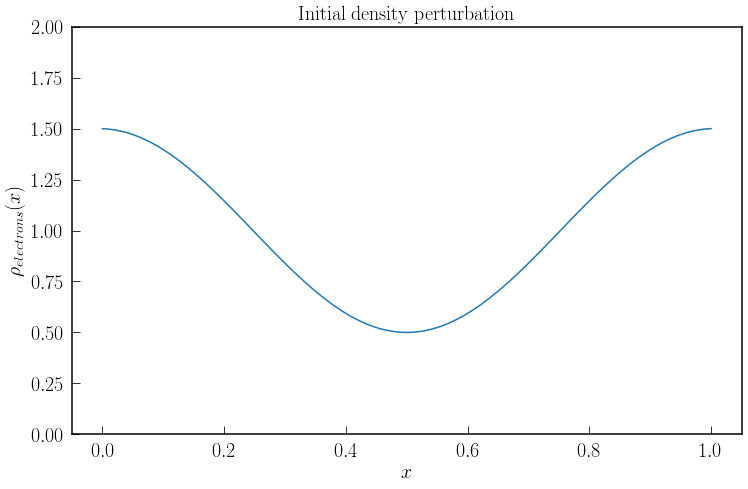

In [12]:
# Plotting the initial distribution

position_grid = np.linspace(0,1,divisions_domain_x)
a, b = np.histogram(positions_x, bins=(divisions_domain_x), range=(0, length_domain_x))
a    = (a / (number_of_electrons / divisions_domain_x))


pl.plot(position_grid, a, label = r'$\rho$')
pl.title(r'$\mathrm{Initial\;density\;perturbation}$')
pl.xlabel('$x$')
pl.ylabel(r'$\rho_{electrons}(x)$')
pl.ylim(0.0,2.0)
pl.show()
pl.clf()

In [13]:
# Time parameters
start_time = 0

end_time   = 3

dt         = 0.01

time       = np.arange(start_time, end_time + dt, dt)

In [14]:
# Some variables for storing data
Ex_all_times = np.zeros(len(time), dtype = np.double)
Ex_max       = np.zeros(len(time), dtype = np.double)

In [15]:
# Plotting the initial conditions
# Finding interpolant fractions for the positions
zone_x = np.floor(((positions_x - x_grid[0]) / dx))
zone_x = zone_x.astype(np.int)
frac_x = (positions_x - x_grid[zone_x]) / (dx)
# Charge deposition using linear weighting scheme

rho      = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
rho      = rho/ number_of_electrons
rho_ions = - np.sum(rho)/len(rho)
rho      = rho + rho_ions

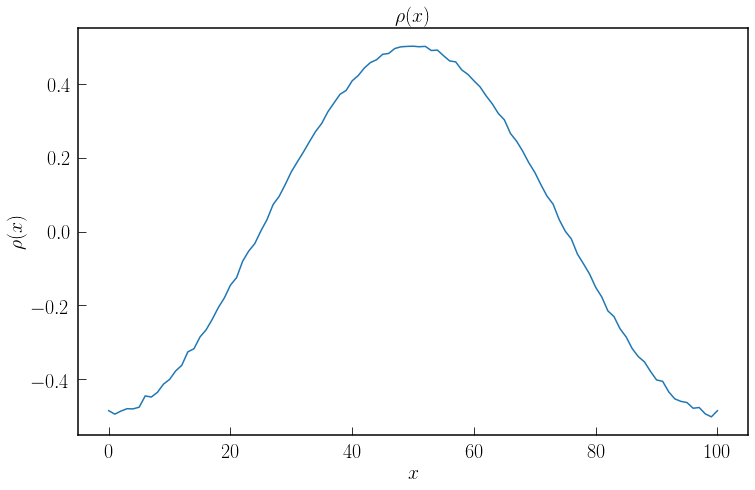

In [16]:
# plotting intial rho in the system considering background ions
pl.plot(rho)
pl.xlabel('$x$')
pl.ylabel(r'$\rho(x)$')
pl.title(r'$\rho(x)$')
pl.show()
pl.clf()

In [17]:
# Computing initial potential and Electric field
V, Ex = fft_poisson(rho,dx)

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


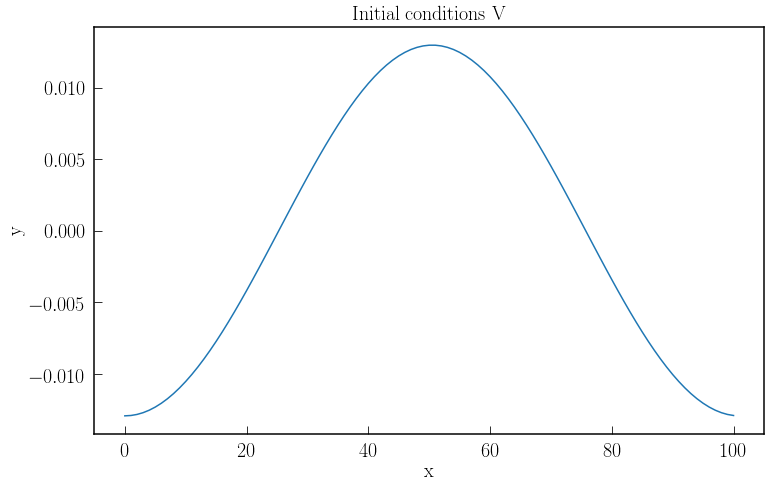

In [18]:
# Plotting the potential for the intial conditions
pl.plot(V)
pl.xlabel('x')
pl.ylabel('y')
pl.title('$\mathrm{Initial\;conditions\;V}$')
pl.show()
pl.clf()

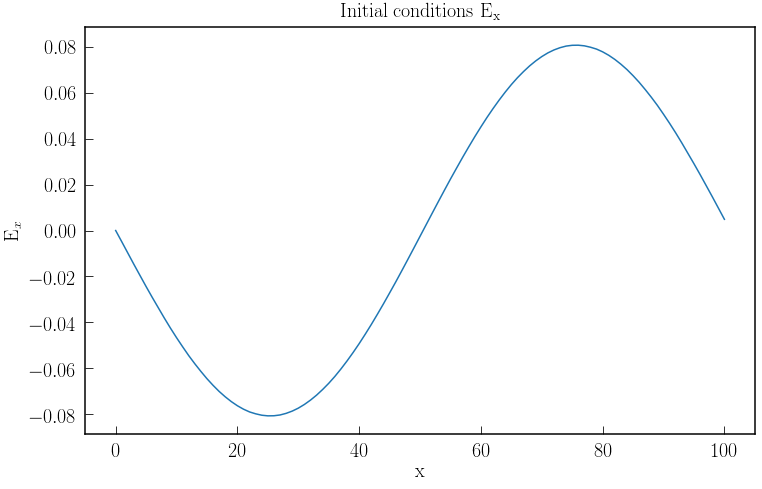

In [19]:
# Plotting the Electric field in the system for the given initial conditions
pl.plot(Ex, label = 'Ex numerical')
pl.xlabel('x')
pl.ylabel('E_{x}')
pl.title('$\mathrm{Initial\;conditions\;E_{x}}$')
pl.show()
pl.clf()

In [20]:
for time_index in range(len(time)):
    if(time_index%100==0):
        print('Computing for time_index = ', time_index)

    # Updating the positions of particle using the velocites

    positions_x += velocity_x * dt

    # Periodic Boundary conditions for particles 

    outside_domain = np.where([positions_x < 0])[1]

    positions_x[outside_domain] = positions_x[outside_domain] + length_domain_x

    outside_domain = np.where([positions_x > length_domain_x])[1]

    positions_x[outside_domain] -= length_domain_x

    # Finding interpolant fractions for the positions

    zone_x = np.floor(((positions_x - x_grid[0]) / dx))
    zone_x = zone_x.astype(np.int)
    frac_x = (positions_x - x_grid[zone_x]) / (dx)

    # Charge deposition using linear weighting scheme

    rho      = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
    rho      = rho/ number_of_electrons
    rho_ions = - np.sum(rho)/len(rho)
    rho      = rho + rho_ions

    # Calculating the potential/Electric field from the charge deposition.

    V, Ex = fft_poisson(rho,dx)

    # Interpolating the fields at each particle
    
    Ex_particle = interpolate.interp1d(x_grid, Ex, kind = 'linear')(positions_x)

    # Updating the velocity using the interpolated Electric fields
    
    velocity_x += (Ex_particle * charge_electron / mass_electron ) * dt

    # Saving the Electric fields for plotting
    
    Ex_all_times[time_index] = np.sum(abs(Ex))
    Ex_max[time_index]       = max(abs(Ex))

    # File writing for saving the data

#     h5f = h5py.File('data/timestepped_data/solution_'+str(time_index)+'.h5', 'w')
#     h5f.create_dataset('positions_x',   data = positions_x)
#     h5f.create_dataset('velocity_x',   data = velocity_x)
#     h5f.create_dataset('Ex',   data = (Ex))
#     h5f.close()

Computing for time_index =  0


/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


Computing for time_index =  100
Computing for time_index =  200
Computing for time_index =  300


### Linear Theory code begins here

$$\mathrm{Setting\;the\;variables\;for\;the\;maxwell\;distribution}$$
$$\sqrt{\left(m/2\pi KT\right)}e^{\left(-mv^{2}/2KT\right)}$$

In [21]:
# Setting the variables in the maxwell distribution
m = 1
K = 1
T = 1
e =charge_electron

In [22]:
# k for the mode in fourier space
k = 2*np.pi
amp = Amplitude_perturbed

$f_0$ is given by
$$\sqrt{\left(m/2\pi KT\right)}e^{\left(-mv^{2}/2KT\right)}$$
$\frac{\partial f_{0}}{\partial v}$ is given by
$$\sqrt{\left(m/2\pi KT\right)}e^{\left(-mv^{2}/2KT\right)}(-mv/KT)$$

In [23]:
# The maxwell Boltzman function
def f_0(v):
    return np.sqrt(m/(2*np.pi*K*T))*np.exp(-m*v**2/(2*K*T))

# This the function which returns the derivative of the maxwell boltzmann equation
def diff_f_0_v(v):
    return np.sqrt(m/(2*np.pi*K*T))*np.exp(-m*v**2/(2*K*T)) * ( -m * v / (K * T))

In [24]:
# Assign the maxim and minimum velocity for the velocity grid
velocity_max =  +10
velocity_min =  -10

In [25]:
# Set the divisions for the velocity grid
number_of_velocities_points = 501
velocity_x                  = np.linspace(velocity_min, velocity_max, number_of_velocities_points)
dv                          = velocity_x[1] - velocity_x[0]

$$\mathrm{Equations\;used\;for\;the\;first\;approach}$$
\begin{align}
\frac{\partial \left(\delta \hat{f}\left(v, t\right)\right)}{\partial t}+ik\;v_{x} \cdot \delta \hat{f}\left(v, t\right)+\left(\frac{q^2}{ik}\left(\int\delta \hat{f}\left(v, t\right).dv\right)\right)\left(\frac{\partial\left(f_{0}\right)}{\partial v}\right)=0
\end{align}

The above equation can be split into a coupled set of ordinary differential equations in the manner shown below: \\
Let the real and imaginary parts of $\delta \hat{f}\left(v, t\right)$ be denoted by $f_{r}$ and $f_{i}$ respectively. This results in the following set of equations: \\
\begin{align}
\frac{\partial f_{r}}{\partial t}=kv_{x}f_{i}-\frac{q^{2}}{k}\left(\int f_{i}dv\right)\frac{\partial f_{0}}{\partial v_{x}} \\
\frac{\partial f_{i}}{\partial t}=-kv_{x}f_{r}+\frac{q^{2}}{k}\left(\int f_{r}dv_{x}\right)\frac{\partial f_{0}}{\partial v_{x}}
\end{align}

In [26]:
# Function that returns df_i/dt and df_r/dt used for odeint function
# See the latex document for more details on the differential equations
# This has been done to split the imaginary and real part of the ODE
def diff_delta_f(Y,t):
    f_r = Y[0:len(velocity_x)]  # Initial conditions for odeint
    f_i = Y[len(velocity_x): 2 * len(velocity_x)]

    int_Df_i = np.sum(f_i) * (velocity_x[1]-velocity_x[0])
    int_Df_r = np.sum(f_r) * (velocity_x[1]-velocity_x[0])

    # This the derivate for f_r and f_i given in the latex document
    dYdt =np.concatenate([(k * velocity_x * f_i) - e*e*(int_Df_i * diff_f_0_v(velocity_x)/k ), \
                           -(k * velocity_x * f_r) + e*e*(int_Df_r * diff_f_0_v(velocity_x)/k )\
                         ], axis = 0)
    # This returns the derivative for the coupled set of ODE

    return dYdt

$$\mathrm{Equations\;used\;for\;the\;second\;approach}$$
\begin{align}
\frac{\partial\left(\delta\hat{f}\left(v,t\right)\right)}{\partial t}+ikv_{x}\delta\hat{f}\left(v,t\right)+\left(\int\int q^{2} v_{x}\delta f(v,t)dv_{x}dt\right)\left(\frac{\partial\left(f_{0}\right)}{\partial v_{x}}\right)=0
\end{align}
Let the real and imaginary of $\delta \hat{f}(v,t)$ be $f_r$ and $f_i$ respectively. The set of coupled differential equations to split the above equation into its real and imaginary components that can be derived from these are:
\begin{align}
\frac{\partial f_{r}}{\partial t}=kv_{x}f_{i}-qE_{r}\frac{\partial f_{0}}{\partial x} \\
\frac{\partial E_{r}}{\partial t}=-\int q v_{x}f_{r}dv_{x} \\
\frac{\partial f_{i}}{\partial t}=-kv_{x}f_{r}-qE_{i}\frac{\partial f_{0}}{\partial x} \\
\frac{\partial E_{i}}{\partial t}=-\int q v_{x}f_{i}dv_{x}
\end{align}

In [27]:
def diff_delta_f_Ex(Y,t):

    f_r = Y[0:len(velocity_x)]  # Initial conditions for odeint
    f_i = Y[len(velocity_x): 2 * len(velocity_x)]
    E_x_r = Y[2 * len(velocity_x)]
    E_x_i = Y[2 * len(velocity_x) + 1]

    int_v_delta_f_dv_i = e * np.sum(f_i * velocity_x) * (dv)
    int_v_delta_f_dv_r = e * np.sum(f_r * velocity_x) * (dv)
    int_v_delta_f_dv = np.array([int_v_delta_f_dv_r, int_v_delta_f_dv_i ] )

    # This the derivate for f_r and f_i given in the latex document
    dYdt =np.concatenate([(    k * velocity_x * f_i) - e*(E_x_r * diff_f_0_v(velocity_x) ), \
                            - (k * velocity_x * f_r) - e*(E_x_i * diff_f_0_v(velocity_x) ), \
                                -1 * int_v_delta_f_dv\
                         ], axis = 0\
                        )
    # This returns the derivative for the coupled set of ODE

    return dYdt

In [28]:
# Set the initial conditions for delta f(v,t) here
delta_f_initial = np.zeros((2 * len(velocity_x)), dtype = np.float)
delta_f_initial[0: len(velocity_x)] = amp * f_0(velocity_x)

delta_f_Ex_initial = np.zeros((2 * len(velocity_x)+2), dtype = np.float)
delta_f_Ex_initial[0 : len(velocity_x)] = amp * f_0(velocity_x)
delta_f_Ex_initial[2 * len(velocity_x) + 1] = -1 * e * (1/k) * np.sum(delta_f_Ex_initial[0: len(velocity_x)] ) * dv

In [29]:
# Setting the parameters for time here
final_time = 3
dt = 0.001
time_ana = np.arange(0, final_time, dt)

In [30]:
# Variable for temperorily storing the real and imaginary parts of delta f used for odeint
initial_conditions_delta_f = np.zeros((2 * len(velocity_x)), dtype = np.float)
old_delta_f = np.zeros((2 * len(velocity_x)), dtype = np.float)


initial_conditions_delta_f_Ex = np.zeros((2 * len(velocity_x) + 2), dtype = np.float)
old_delta_f_Ex = np.zeros((2 * len(velocity_x) + 2 ), dtype = np.float)
# Variable for storing delta rho

In [31]:
delta_rho_kspace_method1  = np.zeros(len(time_ana), dtype = np.float)
delta_rho_kspace_method2  = np.zeros(len(time_ana), dtype = np.float)
Ex_real_amplitude         = np.zeros(len(time_ana), dtype = np.float)
Ex_imag_amplitude         = np.zeros(len(time_ana), dtype = np.float)
Ex_amplitude              = np.zeros(len(time_ana), dtype = np.float)
delta_f_temp              = np.zeros(2 * len(velocity_x), dtype=np.float)
temperory_delta_f_Ex      = np.zeros(2 * len(velocity_x) + 2, dtype=np.float)

In [32]:
for time_index, t0 in enumerate(time_ana):
    if(time_index%1000==0):
        print("Computing for TimeIndex = ", time_index)
        
    t0 = time_ana[time_index]
    
    if (time_index == time_ana.size - 1):
        break
    t1 = time_ana[time_index + 1]
    t = [t0, t1]

    # delta f is defined on the velocity grid


    # Initial conditions for the odeint
    if(time_index == 0):
        # Initial conditions for the odeint for the 2 ODE's respectively for the first time step
        # First column for storing the real values of delta f and 2nd column for the imaginary values
        initial_conditions_delta_f                 = delta_f_initial.copy()
        initial_conditions_delta_f_Ex                 = delta_f_Ex_initial.copy()
        # Storing the integral sum of delta f dv used in odeint

    else:
        # Initial conditions for the odeint for the 2 ODE's respectively for all other time steps
        # First column for storing the real values of delta f and 2nd column for the imaginary values
        initial_conditions_delta_f= old_delta_f.copy()
        initial_conditions_delta_f_Ex= old_delta_f_Ex.copy()
        # Storing the integral sum of delta f dv used in odeint

    # Integrating delta f

    temperory_delta_f = odeint(diff_delta_f, initial_conditions_delta_f, t)[1]
    temperory_delta_f_Ex = odeint(diff_delta_f_Ex, initial_conditions_delta_f_Ex, t)[1]

    # Saving delta rho for current time_index
    delta_rho_kspace_method1[time_index] = ((sum(dv * temperory_delta_f[ 0: len(velocity_x)])))
    delta_rho_kspace_method2[time_index] = ((sum(dv * temperory_delta_f_Ex[ 0: len(velocity_x)])))
    Ex_real_amplitude[time_index] = (e/k)*sum(  dv * temperory_delta_f[ 0: len(velocity_x)]  )
    Ex_imag_amplitude[time_index] = (e/k)*(sum  (  dv * temperory_delta_f_Ex[ 1 * len(velocity_x) : 2 * len(velocity_x)]  ))
    Ex_amplitude[time_index] = np.sqrt( Ex_real_amplitude[time_index]**2 + Ex_imag_amplitude[time_index]**2  )
    # Saving the solution for to use it for the next time step
    old_delta_f = temperory_delta_f.copy()
    old_delta_f_Ex = temperory_delta_f_Ex.copy()

Computing for TimeIndex =  0
Computing for TimeIndex =  1000
Computing for TimeIndex =  2000


### Comparing the plots from both Linear theory calculations and Electrostatic PIC below

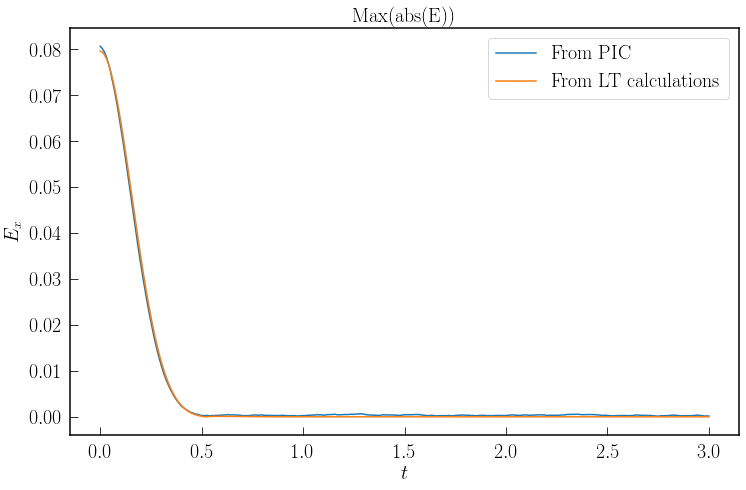

In [33]:
time_grid = np.linspace(0, time[-1], len(Ex_all_times))
pl.plot( time_grid, Ex_max , label = r'$\mathrm{From\;PIC}$')
pl.plot(time_ana, (abs(Ex_amplitude)),label = '$\mathrm{From\;LT\;calculations}$')
pl.title(r'$\mathrm{Max(abs(E))}$')
pl.xlabel('$t$')
pl.ylabel('$E_{x}$')
pl.legend()
pl.show()
# pl.savefig('MaxE.png')
pl.clf()

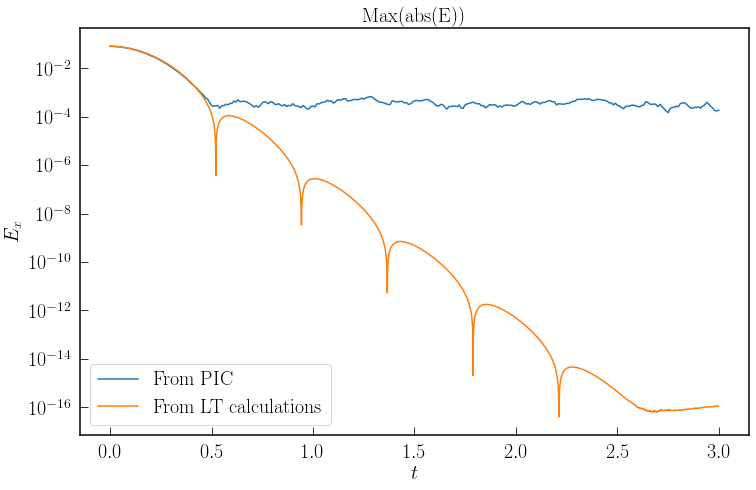

In [34]:
pl.semilogy(time_grid, Ex_max ,label = r'$\mathrm{From\;PIC}$')
pl.semilogy(time_ana, (abs(Ex_amplitude)),label = '$\mathrm{From\;LT\;calculations}$')
pl.legend()
pl.title(r'$\mathrm{Max(abs(E))}$')
pl.xlabel('$t$')
pl.ylabel('$E_{x}$')
pl.show()
# pl.savefig('MaxE_semilogy.png')
pl.clf()

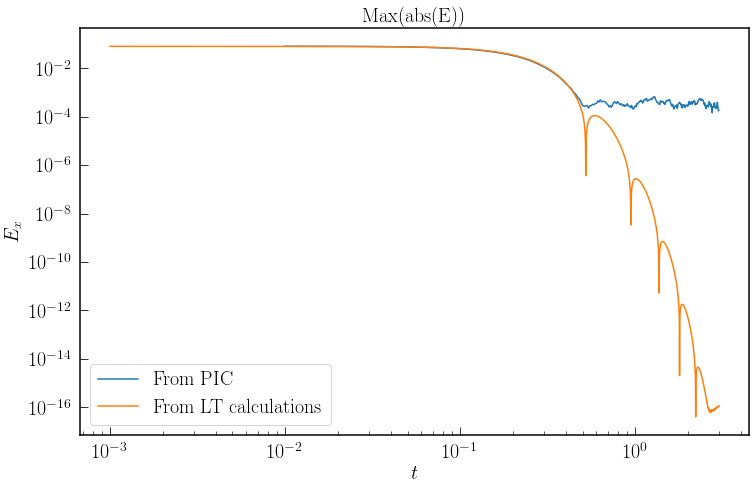

In [35]:
pl.loglog(time_grid, Ex_max ,label = r'$\mathrm{From\;PIC}$')
pl.loglog(time_ana, (abs(Ex_amplitude)),label = '$\mathrm{From\;LT\;calculations}$')
pl.legend()
pl.title(r'$\mathrm{Max(abs(E))}$')
pl.xlabel('$t$')
pl.ylabel('$E_{x}$')
pl.show()
# pl.savefig('MaxE_loglog.png')
pl.clf()